In [87]:
from ultralytics import YOLO
import os
from PIL import Image
import cv2 
import pandas as pd
import networkx as nx
import torch
import matplotlib.pyplot as plt
import numpy as np
#import matplotlib.image as mpimg
import networkx as nx
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model

global_resize_image = (256,256)

In [88]:
imagePath=r"selfie.png"

In [89]:
#Object Detection using YOLOv8
def detect_objects(imagePath):
    image=cv2.imread(imagePath)
    image=cv2.resize(image,global_resize_image)
    model = YOLO('yolov8x.pt')
    result=model(image)
    return result 

In [101]:
results=detect_objects(imagePath)
#print(len(results[0].boxes))
print(results)


0: 640x640 7 persons, 1 handbag, 1 cell phone, 50.5ms
Speed: 1.5ms preprocess, 50.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
9


In [92]:
# Convert to DataFrame
def Convert_to_DataFrame(results):
    boxes = results[0].boxes.xyxy.tolist()
    classes = results[0].boxes.cls.tolist()
    names = results[0].names
    confidences = results[0].boxes.conf.tolist()
    data = {'xmin': [box[0] for box in boxes],
        'ymin': [box[1] for box in boxes],
        'xmax': [box[2] for box in boxes],
        'ymax': [box[3] for box in boxes],
        'confidence': confidences,
        'class': classes,
        'name': [names[int(cls)] for cls in classes]}
    output_df = pd.DataFrame(data)
    #print(output_df)
    return output_df

In [71]:
'''      
def roi_propose(boxes):
    # Function to calculate IoU
    def calculate_iou(box1, box2):
        # Calculate intersection rectangle coordinates
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        # Calculate area of intersection rectangle
        intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
        
        # Calculate area of both bounding boxes
        box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
        box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
        
        # Calculate IoU
        iou = intersection_area / float(box1_area + box2_area - intersection_area)
        
        return iou

    # Calculate IoU matrix
    num_boxes = len(boxes)
    iou_matrix = np.zeros((num_boxes, num_boxes))
    for i in range(num_boxes):
        for j in range(i + 1, num_boxes):
            iou_matrix[i, j] = calculate_iou(boxes[i], boxes[j])
            iou_matrix[j, i] = iou_matrix[i, j]  # IoU is symmetric

    # Define threshold for IoU
    iou_threshold = 0.5

    # Merge bounding boxes based on IoU
    merged = set()
    groups = []
    for i in range(num_boxes):
        if i not in merged:
            group = [i]
            for j in range(i + 1, num_boxes):
                if j not in merged and iou_matrix[i, j] >= iou_threshold:
                    group.append(j)
                    merged.add(j)
            groups.append(group)
    # Merge regions completely inside others
    for i, box1 in enumerate(boxes):
        for j, box2 in enumerate(boxes):
            if i != j and calculate_iou(box1, box2) == 1:
                if i in merged:
                    groups.remove(groups[i])
                elif j in merged:
                    groups.remove(groups[j])
    # Create ROIs based on merged bounding boxes
    rois = {}
    for idx, group in enumerate(groups):
        roi_boxes = [boxes[i] for i in group]
        min_x = min(box[0] for box in roi_boxes)
        min_y = min(box[1] for box in roi_boxes)
        max_x = max(box[2] for box in roi_boxes)
        max_y = max(box[3] for box in roi_boxes)
        rois[idx] = (min_x, min_y, max_x, max_y)

    # Print proposed ROIs
    for roi_id, roi_coords in rois.items():
        print(f"ROI {roi_id}: {roi_coords}")
    return rois    
'''

In [93]:
# Region Proposal       
def roi_propose(boxes):
    # Function to calculate IoU
    def calculate_iou(box1, box2):
        # Calculate intersection rectangle coordinates
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        # Calculate area of intersection rectangle
        intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
        
        # Calculate area of both bounding boxes
        box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
        box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
        
        # Calculate IoU
        iou = intersection_area / float(box1_area + box2_area - intersection_area)
        
        return iou

    # Calculate IoU matrix
    num_boxes = len(boxes)
    iou_matrix = np.zeros((num_boxes, num_boxes))
    for i in range(num_boxes):
        for j in range(i + 1, num_boxes):
            iou_matrix[i, j] = calculate_iou(boxes[i], boxes[j])
            iou_matrix[j, i] = iou_matrix[i, j]  # IoU is symmetric

    # Define threshold for IoU
    iou_threshold = 0.5

    # Merge bounding boxes based on IoU
    merged = set()
    groups = []
    for i in range(num_boxes):
        if i not in merged:
            group = [i]
            for j in range(i + 1, num_boxes):
                if j not in merged and iou_matrix[i, j] >= iou_threshold:
                    group.append(j)
                    merged.add(j)
            groups.append(group)
    # Merge regions completely inside others
    for i, box1 in enumerate(boxes):
        for j, box2 in enumerate(boxes):
            if i != j and calculate_iou(box1, box2) == 1:
                if i in merged:
                    groups.remove(groups[i])
                elif j in merged:
                    groups.remove(groups[j])
    # Create ROIs based on merged bounding boxes
    rois = {}
    for idx, group in enumerate(groups):
        roi_boxes = [boxes[i] for i in group]
        min_x = min(box[0] for box in roi_boxes)
        min_y = min(box[1] for box in roi_boxes)
        max_x = max(box[2] for box in roi_boxes)
        max_y = max(box[3] for box in roi_boxes)
        rois[idx] = (min_x, min_y, max_x, max_y)

    # Function to check if two ROIs overlap
    def is_inside(roi1, roi2):
        x1_min, y1_min, x1_max, y1_max = roi1
        x2_min, y2_min, x2_max, y2_max = roi2
        return (x1_min >= x2_min and y1_min >= y2_min and
                x1_max <= x2_max and y1_max <= y2_max)

    # Function to merge ROIs if one ROI completely encompasses the other
    def merge_overlapping_rois(rois):
        merged_rois = {}
        for idx, roi in rois.items():
            merge = True
            for merged_idx, merged_roi in merged_rois.items():
                if is_inside(roi, merged_roi):
                    # ROI is completely inside another ROI, don't merge
                    merge = False
                    break
                elif is_inside(merged_roi, roi):
                    # Another ROI is completely inside this ROI, merge
                    merged_rois[merged_idx] = roi
                    merge = False
                    break
            if merge:
                merged_rois[idx] = roi
        return merged_rois
    # Merge overlapping ROIs
    merged_rois = merge_overlapping_rois(rois)

    # Print merged ROIs
    for idx, roi in enumerate(merged_rois):
        print(f"ROI {idx}: {roi}")
    '''    
    # Print proposed ROIs
    for roi_id, roi_coords in rois.items():
        print(f"ROI {roi_id}: {roi_coords}")'''
    return merged_rois    


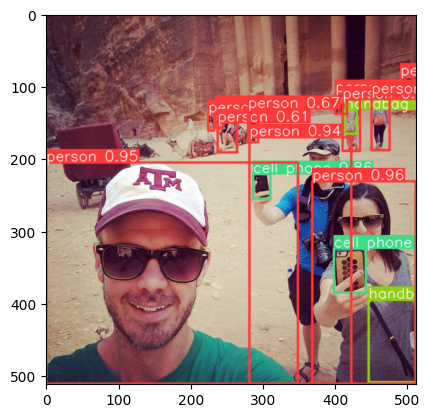

In [82]:
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    #im_array = im_bgr.numpy()
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    #r.show()
    plt.imshow(numpy.array(im_rgb))
    plt.show()

    # Save results to disk
    #r.save(filename=f'results{i}.jpg')

In [102]:
def extract_nodes(image):
    results=detect_objects(image)
    proposed_roi = roi_propose(results[0].boxes.xyxy.tolist())
    output_df=Convert_to_DataFrame(results)
    image_nodes=[]
    for i in range(output_df.shape[0]):
        #print(output_df.iloc[i]['name'])
        data={"object_id":i,
        "start_point":(round(output_df.iloc[i]['xmin']),round(output_df.iloc[i]['ymin'])),
        "ending_point":(round(output_df.iloc[i]['xmax']),round(output_df.iloc[i]['ymax'])),
        "label":output_df.iloc[i]['name']
        }
        image_nodes.append(data)
    return image_nodes    

In [103]:
def generate_nodeImages(imagePath,nodes):
    image=cv2.imread(imagePath)
    image=cv2.resize(image,(256,256))
    #image = cv2.rectangle(image, (106,19), (188,133), (255, 0, 0) , 2) 
    #crop=image[19:133,106:188]
    #cv2.imshow('image',crop)
    #cv2.waitKey()
    segment_array=[]
    for i in range(len(nodes)):
        start=nodes[i].get('start_point')
        end=nodes[i].get('ending_point')
        #print(end[1])
        a,b,c,d=start[1],end[1],start[0],end[0]
        crop=image[a:b,c:d]
        segment_array.append(crop)
    segment_array.append(image)    
    return segment_array    

ROI 0: 0
ROI 1: 1
ROI 2: 2
ROI 3: 3
ROI 4: 4
ROI 5: 6
ROI 6: 7
ROI 7: 8


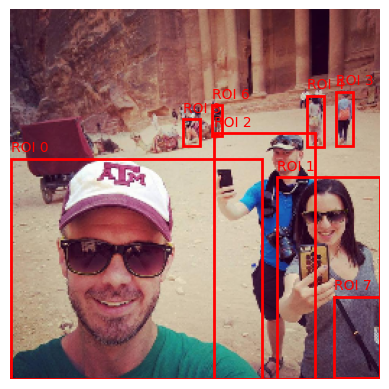

In [99]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to visualize ROIs on the image
def visualize_rois(image_path, rois, save_path):
    # Read the image
    image=cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,global_resize_image)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Draw ROIs on the image
    for roi_id, roi_coords in rois.items():
        min_x, min_y, max_x, max_y = roi_coords
        width = max_x - min_x
        height = max_y - min_y
        rect = patches.Rectangle((min_x, min_y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add text label
        ax.text(min_x, min_y - 5, f'ROI {roi_id}', color='r')

    # Remove axis ticks
    ax.axis('off')

    # Save the image
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

    # Show the image
    plt.show()

# Define image path and save path
#image_path = 'your_image.jpg'
save_path = 'image_with_rois.jpg'

# Visualize ROIs on the image and save
visualize_rois(imagePath, roi_propose(results[0].boxes.xyxy.tolist()), save_path)


In [104]:
nodes=extract_nodes(imagePath)
print(nodes)
#segment_array=generate_nodeImages(imagePath,nodes)
#visualize_graph(segment_array)


0: 640x640 7 persons, 1 handbag, 1 cell phone, 117.1ms
Speed: 2.0ms preprocess, 117.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
ROI 0: 0
ROI 1: 1
ROI 2: 2
ROI 3: 3
ROI 4: 4
ROI 5: 6
ROI 6: 7
ROI 7: 8
[{'object_id': 0, 'start_point': (0, 103), 'ending_point': (174, 256), 'label': 'person'}, {'object_id': 1, 'start_point': (185, 116), 'ending_point': (256, 256), 'label': 'person'}, {'object_id': 2, 'start_point': (141, 85), 'ending_point': (211, 256), 'label': 'person'}, {'object_id': 3, 'start_point': (225, 56), 'ending_point': (237, 94), 'label': 'person'}, {'object_id': 4, 'start_point': (205, 59), 'ending_point': (217, 95), 'label': 'person'}, {'object_id': 5, 'start_point': (143, 111), 'ending_point': (155, 129), 'label': 'cell phone'}, {'object_id': 6, 'start_point': (140, 66), 'ending_point': (146, 87), 'label': 'person'}, {'object_id': 7, 'start_point': (224, 198), 'ending_point': (256, 255), 'label': 'handbag'}, {'object_id': 8, 'start_point': (119, 76)

In [59]:
segment_array=generate_nodeImages(imagePath,nodes)

In [60]:
len(segment_array)

10

In [61]:
#load the VGG19 model:
model=VGG19()
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [62]:
def featuresVGG(segment_array):
    VGG_features=[]
    for image in segment_array:
        image=cv2.resize(image,(224,224))
        image=img_to_array(image)
        image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
        image=preprocess_input(image)
        feature=model.predict(image,verbose=0)
        VGG_features.append(feature)
    return VGG_features    

In [63]:
VGG=featuresVGG(segment_array)

In [64]:
VGG[0].shape

(1, 4096)

In [65]:
print(VGG[0][0])

[          0           0           0 ...           0           0    0.057286]


In [66]:
print(len(VGG))

10


In [21]:
#GCN using Relational Graph Convolution

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch.conv import RelGraphConv
import networkx as nx
import matplotlib.pyplot as plt


g = dgl.DGLGraph()

# Add nodes to the graph
num_nodes = len(VGG)
g.add_nodes(num_nodes)

# Create tensor for node features
features = torch.tensor(VGG, dtype=torch.float32)

# Add features to the graph
g.ndata['features'] = features

# Add edges to the graph with a complete graph
num_edges = num_nodes * (num_nodes - 1)
g.add_edges(torch.randint(num_nodes, (num_edges,)), torch.randint(num_nodes, (num_edges,)))

# Initialize learnable edge weights
g.edata['edge_weights'] = nn.Parameter(torch.rand(num_edges, requires_grad=True))

# GCN model with RelGraphConv layer
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_rels):
        super(GCN, self).__init__()
        self.layer = RelGraphConv(in_feats, hidden_feats, num_rels, activation=F.relu)
        #self.out_layer = nn.Linear(hidden_feats, out_feats)

    def forward(self, g, features):
        g = dgl.remove_self_loop(g)
        # Perform relational graph convolution
        h = self.layer(g, features, g.edata['edge_weights'])
        
        # fully connected layer
        #output = self.out_layer(h)
        return h

# Reshape the features tensor
features = features.squeeze(1)

# Instantiate the GCN model with the number of relations and classes
in_feats = features.shape[1]  # Number of input features
hidden_feats = 256  # Number of hidden units
num_classes = 5  # Number of classes for multiclass classification
num_rels = 10  # Number of relations 

model = GCN(in_feats, hidden_feats, num_classes, num_rels) 

# Forward pass
output = model(g, features)
print(output)
output.shape
# Apply softmax to obtain class probabilities
#probs = F.softmax(output, dim=1)

#print(probs)


tensor([[1.53010, 2.92149, 1.50596,  ..., 1.09558, 0.00000, 3.36610],
        [0.00000, 0.00000, 0.00000,  ..., 0.00000, 1.14462, 2.79518],
        [1.84861, 2.14890, 0.00000,  ..., 0.00000, 0.00000, 2.29957],
        [7.25546, 0.00000, 2.02446,  ..., 0.00000, 0.00000, 0.00000]], grad_fn=<ReluBackward0>)


torch.Size([4, 256])

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [1]:
# GCN model using convetional Convulution Graph Network
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv

g = dgl.DGLGraph()

# Add nodes to the graph
num_nodes = len(VGG)
g.add_nodes(num_nodes)

# Create tensor for node features
features = torch.tensor(VGG, dtype=torch.float32)

# Add features to the graph
g.ndata['features'] = features

# Add edges to the graph with learnable weights initialized randomly
num_edges = num_nodes*num_nodes-1 
g.add_edges(torch.randint(num_nodes, (num_edges,)), torch.randint(num_nodes, (num_edges,)))

# Initialize learnable edge weights
g.edata['edge_weights'] = nn.Parameter(torch.rand(num_edges, requires_grad=True))

# Define a Graph Convolutional Network (GCN) model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats):
        super(GCN, self).__init__()
        self.conv = GraphConv(in_feats, hidden_feats)

    def forward(self, g, features):
        # Perform graph convolution with learnable edge weights
        h = self.conv(g, features)
        h = F.relu(h)
        return h

# Reshape the features tensor
features = features.squeeze(1)

# Instantiate the GCN model
in_feats = features.shape[1] # Number of input features
hidden_feats = 256 # Number of hidden units
model = GCN(in_feats, hidden_feats)

# Forward pass
output_gcn = model(g, features)


print(output_gcn)
output_gcn.shape

c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


NameError: name 'VGG' is not defined

In [123]:
import numpy as np
from torch import Tensor
output=output_gcn.detach().numpy()
#output=np.reshape(output_gcn,output_gcn.shape[1])

In [124]:
output.shape


(4, 256)

In [48]:
#b = output.flatten()
#b=np.reshape(b,b.shape[0])

In [49]:
print(b)

[          0     0.30215      0.6291 ...           0           0     0.72753]


In [76]:
len(b)

1

In [125]:
output=output.transpose()

In [98]:
b=output.reshape(1,-1)

In [99]:
b.shape

(1, 1024)

In [100]:
print(b)

[[    0.50786           0     0.28418 ...      1.3954      5.5616           0]]


In [33]:
#b=np.reshape(b,b.shape[1])

In [34]:
#b.shape

(1024,)

In [126]:
 from sklearn.decomposition import PCA

In [128]:
pca = PCA(n_components=1)
pca.fit(output)

PCA(n_components=1)

In [118]:
pca_b

PCA(n_components=1)

In [129]:
from sklearn.preprocessing import StandardScaler
s=StandardScaler()
x=pca.transform(output)

In [130]:
print(x.shape)

(256, 1)


In [134]:
print(x)

[[    -1.2616]
 [     5.1594]
 [    0.57578]
 [    -1.2616]
 [    0.33297]
 [     0.2496]
 [    -1.0775]
 [    -1.2616]
 [     1.6534]
 [     0.2691]
 [    -0.7258]
 [    -1.1917]
 [   -0.95797]
 [    0.51899]
 [    0.18361]
 [   -0.26904]
 [    -1.2616]
 [    -1.0818]
 [     1.6243]
 [      2.012]
 [    -1.2616]
 [     1.1576]
 [     5.0555]
 [    -1.2616]
 [    -1.0644]
 [     1.3706]
 [    -1.2616]
 [    -1.0471]
 [   -0.66128]
 [     0.3533]
 [    -1.2616]
 [    -1.0162]
 [    -0.5418]
 [      4.545]
 [    -1.2616]
 [    -1.2616]
 [     4.3435]
 [    -1.2173]
 [     4.0678]
 [    -1.2616]
 [    -1.1928]
 [     1.2638]
 [     2.0019]
 [    -1.2616]
 [    -1.2616]
 [   -0.32235]
 [    -1.2616]
 [    -1.2616]
 [     3.1066]
 [    -1.2616]
 [     1.6483]
 [    -1.2616]
 [     1.6423]
 [   -0.89371]
 [   -0.66018]
 [    -1.2616]
 [   -0.72212]
 [    -1.2616]
 [    -1.1859]
 [    -1.2153]
 [  -0.020354]
 [    -1.2616]
 [    -1.2616]
 [   -0.75988]
 [    -1.2616]
 [    0.98595]
 [    -1.2

In [55]:
#output=np.reshape(output,output.shape[1])

In [45]:
#Reshape the output of GCN for LSTM
batch_size = 1  #processing one graph at a time
num_nodes = g.number_of_nodes()
output_gcn = output_gcn.view(batch_size, num_nodes, hidden_feats)

# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        output, _ = self.lstm(x)
        return output


lstm_model = LSTM(hidden_feats, 128)  # 128 hidden units 

# Forward pass 
output_lstm = lstm_model(output_gcn)


print(output_lstm)
output_lstm.shape

tensor([[[ 1.31777e-01, -2.08447e-02, -1.52904e-01, -1.32896e-01,  1.32941e-01,  1.34144e-01,  4.48199e-02,  1.76426e-01,  2.47702e-02, -1.40492e-01,  3.97684e-02, -1.07978e-01,  1.80426e-01, -1.14290e-02,  1.53168e-01,  7.91234e-02,  1.41230e-01, -2.26516e-01,  1.58732e-01, -1.00209e-01, -2.11133e-01, -1.34866e-01,
          -1.56171e-01,  1.26189e-01,  2.00407e-01, -1.26752e-01, -1.42292e-02,  1.49252e-01, -3.14804e-02, -1.07960e-01,  1.55362e-01,  1.04021e-01,  2.98855e-02,  2.33520e-02,  1.03485e-01,  1.86764e-01,  7.54420e-02,  7.36205e-02,  9.82403e-02, -7.73489e-02,  1.24779e-02, -2.84458e-02,  2.23195e-03,  7.30309e-02,
          -6.64143e-02, -4.31541e-02,  1.67844e-01,  3.06843e-02,  3.03529e-02,  9.53403e-02,  9.44292e-02,  5.36023e-02, -5.60734e-02,  1.01189e-01, -4.24863e-03,  1.78458e-02, -2.46704e-01,  2.94786e-02, -2.09040e-01,  1.81564e-01,  2.08055e-01,  2.09826e-02, -8.68400e-02,  1.16171e-01, -1.47190e-02, -9.32746e-02,
           2.64793e-01, -6.98123e-02, -1.87539

torch.Size([1, 3, 128])